#### Import the libraries

In [1]:
import os
from osgeo import gdal
import numpy as np

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


/home/huimin/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


#### Download ERA5 file

In [16]:
import cdsapi

# https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=download

# dataset = "reanalysis-era5-pressure-levels"
dataset = "reanalysis-era5-single-levels"
request = {
    "product_type": ["reanalysis"],
    "variable": [
        # "specific_humidity",  # pressure level
        # "10m_u_component_of_wind",
        # "10m_v_component_of_wind",
        # "2m_temperature",
        # "surface_pressure",

        # "mean_total_precipitation_rate",
        # "mean_surface_downward_short_wave_radiation_flux",
        "mean_surface_downward_long_wave_radiation_flux"

        # "total_precipitation",
        # "surface_solar_radiation_downwards",
        # "surface_thermal_radiation_downwards",
        # "surface_solar_radiation_downward_clear_sky",
        # "surface_thermal_radiation_downward_clear_sky",
    ],
    # "pressure_level": ['1000'],  # Select pressure levels of interest

    "year": ["2023"],

    "month": ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"],
    "day": ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12",
            "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24",
            "25", "26", "27", "28", "29", "30", "31"],
    "time": ["00:00", "01:00", "02:00", "03:00", "04:00", "05:00", "06:00", "07:00", "08:00",
            "09:00", "10:00", "11:00", "12:00", "13:00", "14:00", "15:00", "16:00", "17:00",
            "18:00", "19:00", "20:00", "21:00", "22:00", "23:00"],

    # "data_format": "grib", "download_format": "zip",
    "data_format": "grib", "download_format": "unarchived",
    "area": [48, 6.3, 42, 15] # North, West, South, East.
}

client = cdsapi.Client()
client.retrieve(dataset, request).download('../../Data/GRB/avg_sdlwrf.grib')


2025-02-06 17:34:02,982 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-06 17:34:02,983 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-02-06 17:34:03,269 INFO Request ID is b233f79a-f645-40e8-9a31-9d35110b9b72
2025-02-06 17:34:03,315 INFO status has been updated to accepted
2025-02-06 17:34:08,409 INFO status has been updated to running
2025-02-06 17:43:10,425 INFO status has been updated to successful


'../../Data/GRB/avg_sdlwrf.grib'

In [17]:
check_download = xr.open_dataset('../../Data/GRB/avg_sdlwrf.grib', engine='cfgrib')
print(check_download)

<xarray.Dataset> Size: 31MB
Dimensions:     (time: 731, step: 12, latitude: 25, longitude: 35)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 6kB 2022-12-31T18:00:00 ... 2023-12-31T...
  * step        (step) timedelta64[ns] 96B 01:00:00 02:00:00 ... 12:00:00
    surface     float64 8B ...
  * latitude    (latitude) float64 200B 48.0 47.75 47.5 ... 42.5 42.25 42.0
  * longitude   (longitude) float64 280B 6.3 6.55 6.8 7.05 ... 14.3 14.55 14.8
    valid_time  (time, step) datetime64[ns] 70kB ...
Data variables:
    avg_sdlwrf  (time, step, latitude, longitude) float32 31MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-06T17:47 GRIB to CDM+CF via cfgrib-0.9.1...


#### Modify the mean_total_precipitation_rate, tot_precip, short wave, long wave - forecast variables

In [18]:
# Use this part when step represnet sequential lead times

# Please check the start time and end time of the dataset
# The 4 forecast dataset, start time: 2023-12-31T18:00:00, end time: 2020-12-31T18:00:00, 12 steps
# The other 5 analysis dataset, start time: 2020-01-01T00:00:00, end time: 2020-12-31T23:00:00

forecast_grib = {
    "avg_tprate": "../../Data/GRB/avg_tprate.grib",
    "avg_sdswrf": "../../Data/GRB/avg_sdswrf.grib",
    "avg_sdlwrf": "../../Data/GRB/avg_sdlwrf.grib",
}

for key in forecast_grib.keys():
    data = xr.open_dataset(forecast_grib[key], engine='cfgrib')

    # Ensure broadcasting of 'step' over 'time' for proper valid_time calculation
    time_expanded, step_expanded = xr.broadcast(data.time, data.step)
    valid_time = time_expanded + step_expanded

    # Assign the new valid_time coordinate
    data = data.assign_coords(valid_time=(("time", "step"), valid_time.data))

    # Now, stack (time, step) into a single dimension
    data_hourly = data.stack(real_time=("time", "step"))

    # Replace the old dimension with 'valid_time'
    data_hourly = data_hourly.swap_dims({"real_time": "valid_time"}).drop_vars("real_time")

    # Reorder dimensions for consistency
    data_hourly = data_hourly.transpose("valid_time", "latitude", "longitude")

    # Ensure chronological order and remove potential duplicates
    data_hourly = data_hourly.sortby("valid_time").drop_duplicates(dim="valid_time")

    # remove the first 6 and the last 6 hours
    data_hourly = data_hourly.sel(valid_time=slice("2023-01-01T00:00:00", "2023-12-31T23:00:00"))

    save_path = f"../../Data/NC/{key}_hourly.nc"
    data_hourly.to_netcdf(save_path)


In [19]:
check_nc = xr.open_dataset("../../Data/NC/avg_sdlwrf_hourly.nc")
print(check_nc)
print(check_nc.valid_time)


<xarray.Dataset> Size: 31MB
Dimensions:     (latitude: 25, longitude: 35, valid_time: 8760)
Coordinates:
    number      int64 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 200B 48.0 47.75 47.5 ... 42.5 42.25 42.0
  * longitude   (longitude) float64 280B 6.3 6.55 6.8 7.05 ... 14.3 14.55 14.8
  * valid_time  (valid_time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23...
    time        (valid_time) datetime64[ns] 70kB ...
    step        (valid_time) timedelta64[ns] 70kB ...
Data variables:
    avg_sdlwrf  (valid_time, latitude, longitude) float32 31MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-06T17:49 GRIB to CDM+CF via cfgrib-0.9.1...
<xarray.DataArray 'valid

In [4]:
# Modify in this way when step contains independent values that do not form a continuous time sequence → aggregate over step.
import pandas as pd

# Generate the expected hourly time range
expected_time = pd.date_range(start="2020-01-01", periods=8760, freq="h")

for key in forecast_grib.keys():
    data = xr.open_dataset(forecast_grib[key],engine='cfgrib')
    data = data.mean(dim="step")
    data = data.interp(time=expected_time) # Reindex and interpolate
    save_path = f"../../Data/NC/{key}.nc"
    data.to_netcdf(save_path)


In [21]:
forecast_nc ={
    # "tp": "../../Data/NC/tp_hourly.nc",
    "avg_tprate": "../../Data/NC/avg_tprate_hourly.nc",
    "avg_sdlwrf": "../../Data/NC/avg_sdlwrf_hourly.nc",
    "avg_sdswrf": "../../Data/NC/avg_sdswrf_hourly.nc"
}

# Check the nan values
# for varaible in forecast_nc.keys():
#     ds = xr.open_dataset(forecast_nc[varaible])
#     # check the nan values
#     value = ds[varaible].values
#     print(np.isnan(value).sum())  # 0

# Remap the nc files to the target grid
for variable in forecast_nc:
    os.system('cdo remapbil,../../Data/TXT/gridtype_andreas_domain.txt '+forecast_nc[variable]+' '+forecast_nc[variable].replace('.nc', '_remapped.nc'))


Warning (find_time_vars): Found more than one time variable, skipped variable time!
Warning (cdfInqContents): Coordinates variable number can't be assigned!
Warning (cdfInqContents): Coordinates variable time can't be assigned!
Warning (cdfInqContents): Coordinates variable step can't be assigned!
Warning (cdfInqContents): Coordinates variable surface can't be assigned!


cdo    remapbil: Bilinear weights from lonlat (35x25) to lonlat (265x165) grid
cdo    remapbil: Processed 7665000 values from 1 variable over 8760 timesteps [24.88s 79MB].


Warning (find_time_vars): Found more than one time variable, skipped variable time!
Warning (cdfInqContents): Coordinates variable number can't be assigned!
Warning (cdfInqContents): Coordinates variable time can't be assigned!
Warning (cdfInqContents): Coordinates variable step can't be assigned!
Warning (cdfInqContents): Coordinates variable surface can't be assigned!


cdo    remapbil: Bilinear weights from lonlat (35x25) to lonlat (265x165) grid
cdo    remapbil: Processed 7665000 values from 1 variable over 8760 timesteps [13.47s 80MB].


Warning (find_time_vars): Found more than one time variable, skipped variable time!
Warning (cdfInqContents): Coordinates variable number can't be assigned!
Warning (cdfInqContents): Coordinates variable time can't be assigned!
Warning (cdfInqContents): Coordinates variable step can't be assigned!
Warning (cdfInqContents): Coordinates variable surface can't be assigned!


cdo    remapbil: Bilinear weights from lonlat (35x25) to lonlat (265x165) grid
cdo    remapbil: Processed 7665000 values from 1 variable over 8760 timesteps [18.03s 79MB].


<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 8760, lon: 265, lat: 165)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23...
  * lon         (lon) float64 2kB 6.493 6.519 6.544 6.569 ... 13.08 13.1 13.13
  * lat         (lat) float64 1kB 43.55 43.57 43.58 43.6 ... 46.61 46.63 46.65
Data variables:
    leadtime    (valid_time) timedelta64[ns] 70kB ...
    avg_sdswrf  (valid_time, lat, lon) float32 2GB ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    history:                 Thu Feb 06 17:52:29 2025: cdo remapbil,../../Dat...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...
(8760, 165, 265)


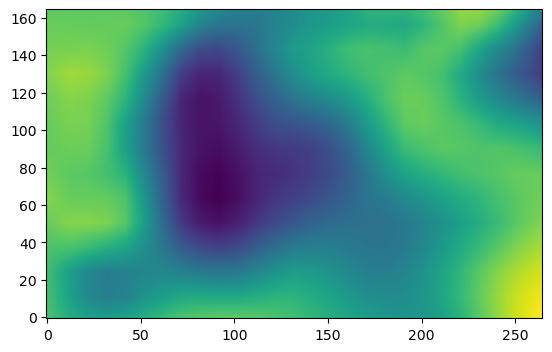

In [ ]:
check_nc_remapped = xr.open_dataset("../../Data/NC/avg_sdswrf_hourly_remapped.nc")
print(check_nc_remapped)
check_data_remapped = check_nc_remapped.avg_sdswrf.values
print(check_data_remapped.shape)
plt.imshow(check_data_remapped[10], origin = 'lower')

In [3]:
nc_remapped ={
    # "tp": "../../Data/NC/tp_hourly_remapped.nc",
    "avg_tprate": "../../Data/NC/avg_tprate_hourly_remapped.nc",
    "avg_sdlwrf": "../../Data/NC/avg_sdlwrf_hourly_remapped.nc",
    "avg_sdswrf": "../../Data/NC/avg_sdswrf_hourly_remapped.nc"
}

for var_name, file_path in nc_remapped.items():
    ds = xr.open_dataset(file_path)

    # Convert the xarray dataset to a dictionary for saving
    data_dict = {var: ds[var].values for var in ds.data_vars}
    data_dict["lat"] = ds["lat"].values
    data_dict["lon"] = ds["lon"].values

    # Save the dictionary as a .npz file
    np.savez(f"../../Data/NPZ/FORCING_lombardy.{var_name}.000000_to_008760.npz", **data_dict)


['leadtime', 'avg_tprate', 'lat', 'lon']
(8760, 165, 265)


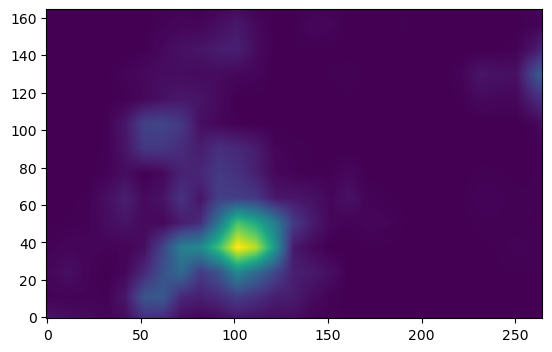

In [2]:
check_npz = np.load("../../Data/NPZ/FORCING_lombardy.avg_tprate.000000_to_008760.npz")
print(check_npz.files)
print(check_npz['avg_tprate'].shape)
plt.imshow(check_npz['avg_tprate'][10], origin = 'lower')

In [3]:
variables = ["SPFH", "UGRD", "VGRD", "Temp", "Press", "APCP", "DLWR", "DSWR"]
forcing_2018 = []

for var in variables:
    path = np.load(f'../../Data/NPZ/forcing_2018/FORCING_lombardy.{var}.000000_to_008760.npz')
    key = path.files[0]
    forcing_2018.append(path[key])

In [4]:
# Check the modified longwave radiation file
DLWR_2023_path = np.load('../../Data/NPZ/FORCING_lombardy.avg_sdlwrf.000000_to_008760.npz')
DLWR_2023 = DLWR_2023_path['avg_sdlwrf']
# filter out the nan values, nan is replaced by 0
# DLWR_2020[DLWR_2020 == np.nan] = 0

DLWR_2018 = forcing_2018[6]
# DLWR_2018[DLWR_2018 == np.nan] = 0

mean_DLWR_2023 = np.nanmean(DLWR_2023, axis=0)
mean_DLWR_2018 = np.nanmean(DLWR_2018, axis=0)

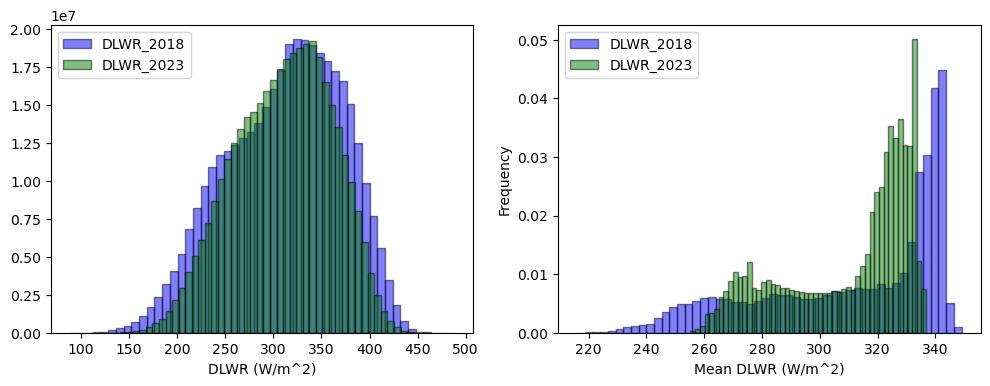

In [5]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(DLWR_2018.flatten(), bins=50, color='blue', edgecolor='k', alpha=0.5, label='DLWR_2018')
plt.hist(DLWR_2023.flatten(), bins=50, color='green', edgecolor='k', alpha=0.5, label='DLWR_2023')
plt.xlabel('DLWR (W/m^2)')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(mean_DLWR_2018.flatten(), bins=50, density=True, color='blue', edgecolor='k', alpha=0.5, label='DLWR_2018')
plt.hist(mean_DLWR_2023.flatten(), bins=50, density=True, color='green', edgecolor='k', alpha=0.5, label='DLWR_2023')
plt.xlabel('Mean DLWR (W/m^2)')
plt.ylabel('Frequency')
plt.legend()

In [6]:
# Check the modified longwave radiation file
DSWR_2023_path = np.load('../../Data/NPZ/FORCING_lombardy.avg_sdswrf.000000_to_008760.npz')
DSWR_2023 = DSWR_2023_path['avg_sdswrf']
# filter out the nan values, nan is replaced by 0
DSWR_2023[DSWR_2023 == np.nan] = 0

DSWR_2018 = forcing_2018[7]

mean_DSWR_2018 = np.nanmean(DSWR_2018, axis=0)
mean_DSWR_2023 = np.nanmean(DSWR_2023, axis=0)

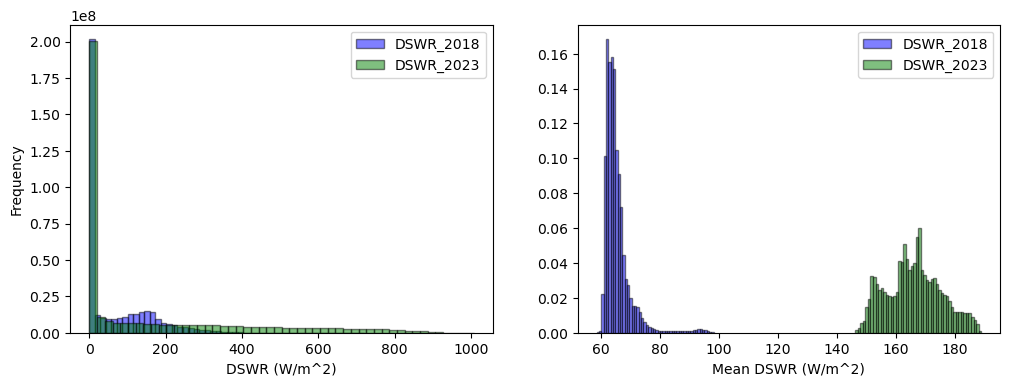

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(DSWR_2018.flatten(), bins=50, color='blue', edgecolor='k', alpha=0.5, label='DSWR_2018')
plt.hist(DSWR_2023.flatten(), bins=50, color='green', edgecolor='k', alpha=0.5, label='DSWR_2023')
plt.xlabel('DSWR (W/m^2)')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(mean_DSWR_2018.flatten(), bins=50, density=True, color='blue', edgecolor='k', alpha=0.5, label='DSWR_2018')
plt.hist(mean_DSWR_2023.flatten(), bins=50, density=True, color='green', edgecolor='k', alpha=0.5, label='DSWR_2023')
plt.xlabel('Mean DSWR (W/m^2)')
plt.legend()


In [8]:
# ACPC_2023 = xr.open_dataset('../../Data/NC/tp_clipped.nc')
# ACPC_2023 = ACPC_2023['tp'].values
# print(ACPC_2023)
ACPC_2023_path = np.load('../../Data/NPZ/FORCING_lombardy.avg_tprate.000000_to_008760.npz')
ACPC_2023 = ACPC_2023_path['avg_tprate']
ACPC_2023[np.isnan(ACPC_2023)] = 0

ACPC_2018 = forcing_2018[5]

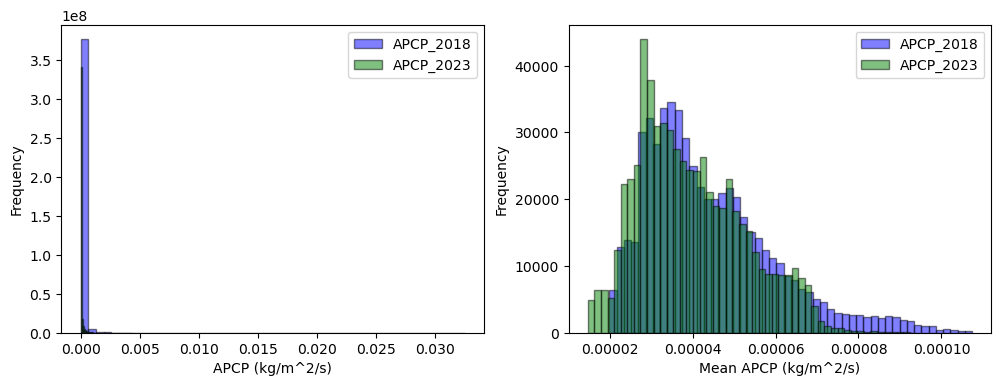

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(ACPC_2018.flatten(), bins=50, color='blue', edgecolor='k', alpha=0.5, label='APCP_2018')
plt.hist(ACPC_2023.flatten(), bins=50, color='green', edgecolor='k', alpha=0.5, label='APCP_2023')
plt.xlabel('APCP (kg/m^2/s)')
plt.ylabel('Frequency')
plt.legend()

mean_ACPC_2018 = np.nanmean(ACPC_2018, axis=0)
mean_ACPC_2023 = np.nanmean(ACPC_2023, axis=0)

plt.subplot(1, 2, 2)
plt.hist(mean_ACPC_2018.flatten(), bins=50, density=True, color='blue', edgecolor='k', alpha=0.5, label='APCP_2018')
plt.hist(mean_ACPC_2023.flatten(), bins=50, density=True, color='green', edgecolor='k', alpha=0.5, label='APCP_2023')
plt.xlabel('Mean APCP (kg/m^2/s)')
plt.ylabel('Frequency')
plt.legend()

#### Save the analysis variables

In [10]:
# List of GRIB file paths and corresponding variable names
grib_files = {
    "q": "../../Data/GRB/q.grib",
    "u10": "../../Data/GRB/u10.grib",
    "v10": "../../Data/GRB/v10.grib",
    "t2m": "../../Data/GRB/t2m.grib",
    "sp": "../../Data/GRB/sp.grib",

    # "tp": "../../Data/GRB/tp_sub_hourly.grib",
    # "avg_tprate": "../../Data/GRB/avg_tprate.grib",
    # "avg_sdlwrf": "../../Data/GRB/avg_sdlwrf.grib",
    # "avg_sdswrf": "../../Data/GRB/avg_sdswrf.grib"
}

# Check the nan values
# for variable in grib_files.keys():
#     ds = xr.open_dataset(grib_files[variable], engine='cfgrib')
#     value = ds[variable].values
#     print(np.isnan(value).sum())

# Remap the 5 .grib file to the desired grid
for variable in grib_files.keys():
    os.system('cdo remapbil,../../Data/TXT/gridtype_andreas_domain.txt '+grib_files[variable]+' ../../Data/GRB/'+variable+'_remapped.grib')


cdo    remapbil: Bilinear weights from lonlat (35x25) to lonlat (265x165) grid
cdo    remapbil: Processed 7665000 values from 1 variable over 8760 timesteps [37.41s 80MB].
cdo    remapbil: Bilinear weights from lonlat (35x25) to lonlat (265x165) grid
cdo    remapbil: Processed 7665000 values from 1 variable over 8760 timesteps [32.22s 79MB].
cdo    remapbil: Bilinear weights from lonlat (35x25) to lonlat (265x165) grid
cdo    remapbil: Processed 7665000 values from 1 variable over 8760 timesteps [40.73s 72MB].
cdo    remapbil: Bilinear weights from lonlat (35x25) to lonlat (265x165) grid
cdo    remapbil: Processed 7665000 values from 1 variable over 8760 timesteps [33.71s 80MB].
cdo    remapbil: Bilinear weights from lonlat (35x25) to lonlat (265x165) grid
cdo    remapbil: Processed 7665000 values from 1 variable over 8760 timesteps [39.84s 72MB].


In [11]:
check_grib_remapped = xr.open_dataset("../../Data/GRB/t2m_remapped.grib", engine='cfgrib')
print(check_grib_remapped)

<xarray.Dataset> Size: 2GB
Dimensions:     (time: 8760, latitude: 165, longitude: 265)
Coordinates:
  * time        (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 1kB 43.55 43.56 43.58 ... 46.62 46.64 46.65
  * longitude   (longitude) float64 2kB 6.493 6.518 6.543 ... 13.08 13.1 13.13
    valid_time  (time) datetime64[ns] 70kB ...
Data variables:
    t2m         (time, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-06T18:32 GRIB to CDM+CF via cfgrib-0.9.1...


In [12]:
import glob

for idx in glob.glob("../../Data/GRB/*.idx"):
    os.remove(idx)
print("All .idx files deleted.")

for identi in glob.glob("../../Data/NPZ/*.Identifier"):
    os.remove(identi)

All .idx files deleted.


In [ ]:
# Plot a variable
# q.isel(time=0).plot()
# Create a plot with a basemap
# fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# # specific_humidity.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
# # mtpr.isel(time=9, step=1).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# # Add coastlines and gridlines
# ax.coastlines()
# gl = ax.gridlines(draw_labels=True)
# gl.top_labels = False
# gl.right_labels = False

# Mask = np.loadtxt('../../Data/TXT/Mask.txt')
# # plt.imshow(specific_humidity[0,:,:], cmap='viridis')
# plt.imshow(mtpr_data[9,0,:,:], cmap='viridis')

# plt.contour(Mask, levels=[0.5], colors='red')
# plt.title('Specific Humidity at Time Index 0')
# plt.show()

In [13]:
# Save the 5 grid files to .npz files
grib_remapped = {
    "q": "../../Data/GRB/q_remapped.grib",
    "u10": "../../Data/GRB/u10_remapped.grib",
    "v10": "../../Data/GRB/v10_remapped.grib",
    "t2m": "../../Data/GRB/t2m_remapped.grib",
    "sp": "../../Data/GRB/sp_remapped.grib",
}

for var_name, file_path in grib_remapped.items():
    ds = xr.open_dataset(file_path, engine="cfgrib")
    # Convert the xarray dataset to a dictionary for saving
    data_dict = {var: ds[var].values for var in ds.data_vars}
    data_dict["lat"] = ds["latitude"].values
    data_dict["lon"] = ds["longitude"].values

    # Save the dictionary as a .npz file
    np.savez(f"../../Data/NPZ/FORCING_lombardy.{var_name}.000000_to_008760.npz", **data_dict)


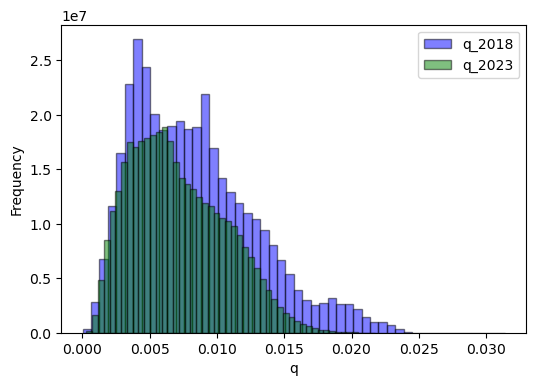

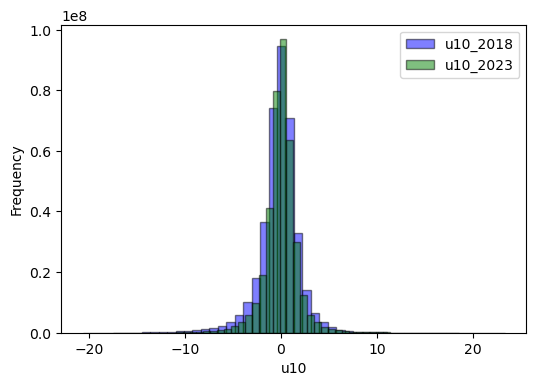

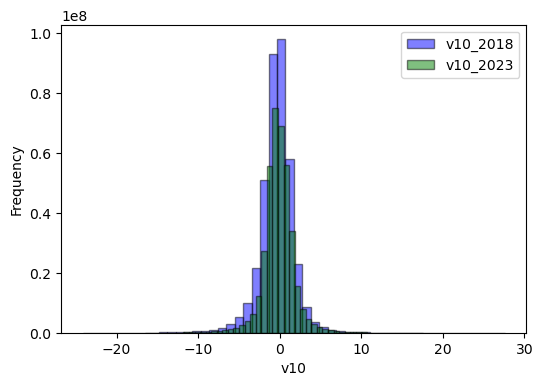

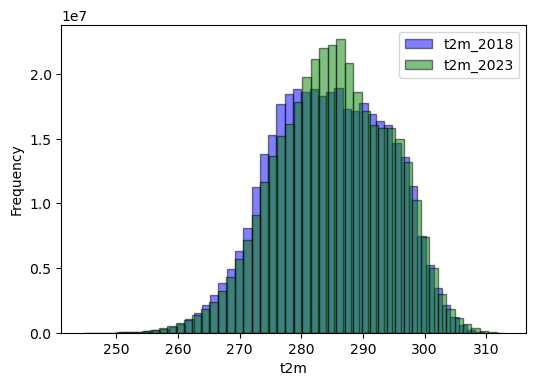

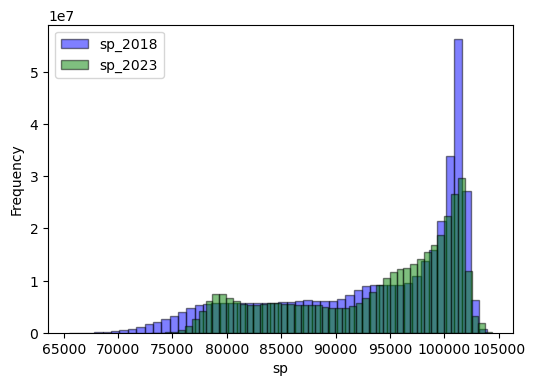

In [14]:
vars = ["q", "u10", "v10", "t2m", "sp"]

for i, var in enumerate(vars):
    path = np.load(f'../../Data/NPZ/FORCING_lombardy.{var}.000000_to_008760.npz')
    var_2020 = path[var]

    plt.figure(figsize=(6, 4))
    plt.hist(forcing_2018[i].flatten(), bins=50, color='blue', edgecolor='k', alpha=0.5, label=var+'_2018')
    plt.hist(var_2020.flatten(), bins=50, color='green', edgecolor='k', alpha=0.5, label=var+'_2023')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
